In [48]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *

In [54]:
def locallization(B):
    W = np.zeros([40,40])
    L = 10
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

In [55]:
nT = 800
nk = 20
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')
print("input B", np.trace(B))
np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)

x_b_save = np.array([x_a_init])

x_a_save = np.array([x_a_init])
#print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

#B_temp_2 = B.copy()
#B_a = np.reshape(B_temp_2,[40,40,1])
#B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)
x_b_k_collect_save = []

while tt <=nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    # background
    if tt == 0:
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B, H))+R)))
        K = np.reshape(K_i, [1,40,40])
        x_b = x_b_save[tt].transpose()
    else:
        k_i = np.split(K, ttf)[tt]
        x_b_k_slice = np.reshape(np.split(x_b_k_collect_save, ttf-1)[tt-1], [nk,40])
    
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        np.random.seed(20181130 - e - 2*tt)
        if tt==0:

            E_e = 0.25 #initial ensamble error
            x_b = x_b.copy() + E_e * np.random.randn(N)
        else:
            x_b  = np.reshape(np.split(x_b_k_slice, nk)[e],[40])
        
        
        # observation
        y_o = y_o_save[tt].transpose()
        # perturb observation
        np.random.seed(20191130 + e + 5*tt)
        y_o_k = y_o + observation_error * np.random.randn(N)
        
        # innovation
        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        x_a = x_b + np.dot(K_i, d)
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        solver = ode(lorenz96.f).set_integrator('dopri5')
        solver.set_initial_value(x_a.transpose() , Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])
    if tt == 0:
        x_b_k_collect_save = np.reshape(x_b_k_save, [1,nk,40])
    else:
        x_b_k_collect_save = np.vstack([x_b_k_collect_save, [x_b_k_save]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save, x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    #do the poll
    
    PH = np.cov(x_b_k_save, rowvar = False)
    HPH = np.cov(x_b_k_save, rowvar = False)
    
    print("PH = ", np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))
    print("K = ", np.trace(K_ip1))
    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis = 0)
    #print(np.trace(HPH))
    tt += 1

#save background and analysis data
print(x_b_save.shape)
print(x_a_save.shape)
x_b_save = x_b_save[0:801][:].copy()
x_a_save = x_a_save[1:802][:].copy()

#np.savetxt('x_b_k200_l10_modelerror0.08.txt', x_b_save)
#np.savetxt('x_a_k200_l10_modelerror0.08.txt', x_a_save)

input B 3.3760000000000003
Cycle = 0 , Ta = 0.0 , Tf = 0.05
PH =  4.8190542977926585
K =  6.489045824612111
Cycle = 1 , Ta = 0.05 , Tf = 0.1
PH =  2.900464613713126
K =  5.008825145423043
Cycle = 2 , Ta = 0.1 , Tf = 0.15
PH =  1.8954083526666452
K =  3.9381665611475967
Cycle = 3 , Ta = 0.15 , Tf = 0.2
PH =  1.269018308261149
K =  3.141487737528326
Cycle = 4 , Ta = 0.2 , Tf = 0.25
PH =  0.910869062919061
K =  2.5963293079616774
Cycle = 5 , Ta = 0.25 , Tf = 0.3
PH =  0.732077396079099
K =  2.270645280990004
Cycle = 6 , Ta = 0.3 , Tf = 0.35
PH =  0.6147341285938462
K =  1.9956672220075538
Cycle = 7 , Ta = 0.35 , Tf = 0.4
PH =  0.5411817588851403
K =  1.8093447890689665
Cycle = 8 , Ta = 0.4 , Tf = 0.45
PH =  0.4608128548842898
K =  1.5761978176916842
Cycle = 9 , Ta = 0.45 , Tf = 0.5
PH =  0.4196916432761765
K =  1.454705951414931
Cycle = 10 , Ta = 0.5 , Tf = 0.55
PH =  0.41375272958702847
K =  1.445228469797227
Cycle = 11 , Ta = 0.55 , Tf = 0.6
PH =  0.36915546055153414
K =  1.288635277699

PH =  0.378363381880951
K =  1.3388219077224859
Cycle = 101 , Ta = 5.05 , Tf = 5.1
PH =  0.3875642717332036
K =  1.3641654140758392
Cycle = 102 , Ta = 5.1 , Tf = 5.15
PH =  0.3731165992290128
K =  1.3186923091822575
Cycle = 103 , Ta = 5.15 , Tf = 5.2
PH =  0.3536440201805838
K =  1.254236841173642
Cycle = 104 , Ta = 5.2 , Tf = 5.25
PH =  0.331371708798363
K =  1.1858402274630817
Cycle = 105 , Ta = 5.25 , Tf = 5.3
PH =  0.33243226551935495
K =  1.1938457428194937
Cycle = 106 , Ta = 5.3 , Tf = 5.35
PH =  0.33719700402420844
K =  1.2174601551897926
Cycle = 107 , Ta = 5.35 , Tf = 5.4
PH =  0.3355818446258476
K =  1.2132523187280495
Cycle = 108 , Ta = 5.4 , Tf = 5.45
PH =  0.3571216120312311
K =  1.2802287472167024
Cycle = 109 , Ta = 5.45 , Tf = 5.5
PH =  0.3853982403411041
K =  1.373130025089187
Cycle = 110 , Ta = 5.5 , Tf = 5.55
PH =  0.3939394594834118
K =  1.394129634020269
Cycle = 111 , Ta = 5.55 , Tf = 5.6
PH =  0.41023988246309195
K =  1.433191577220294
Cycle = 112 , Ta = 5.6 , Tf = 

PH =  0.46475837819643506
K =  1.5624006940882507
Cycle = 199 , Ta = 9.95 , Tf = 10.0
PH =  0.46440602619459675
K =  1.5526167207425021
Cycle = 200 , Ta = 10.0 , Tf = 10.05
PH =  0.46008754749105363
K =  1.5494388548322422
Cycle = 201 , Ta = 10.05 , Tf = 10.1
PH =  0.4440844244675023
K =  1.520263259796847
Cycle = 202 , Ta = 10.1 , Tf = 10.15
PH =  0.436304305527088
K =  1.5122229045787647
Cycle = 203 , Ta = 10.15 , Tf = 10.2
PH =  0.43794862289843806
K =  1.5228815549017012
Cycle = 204 , Ta = 10.2 , Tf = 10.25
PH =  0.4318104228634636
K =  1.4909394722468092
Cycle = 205 , Ta = 10.25 , Tf = 10.3
PH =  0.42889733141540304
K =  1.4655694483398876
Cycle = 206 , Ta = 10.3 , Tf = 10.35
PH =  0.4490443784767842
K =  1.4924988616684818
Cycle = 207 , Ta = 10.35 , Tf = 10.4
PH =  0.44537300207750363
K =  1.4676070230907081
Cycle = 208 , Ta = 10.4 , Tf = 10.45
PH =  0.43423529339923567
K =  1.4527187663612793
Cycle = 209 , Ta = 10.45 , Tf = 10.5
PH =  0.44203858905879445
K =  1.4765888337538464


K =  1.5317964507593738
Cycle = 294 , Ta = 14.7 , Tf = 14.75
PH =  0.45000763740223226
K =  1.522936657910287
Cycle = 295 , Ta = 14.75 , Tf = 14.8
PH =  0.47873890424292065
K =  1.5958411477461762
Cycle = 296 , Ta = 14.8 , Tf = 14.85
PH =  0.5224907967213481
K =  1.711809090340291
Cycle = 297 , Ta = 14.85 , Tf = 14.9
PH =  0.553243631503935
K =  1.7604626187529968
Cycle = 298 , Ta = 14.9 , Tf = 14.95
PH =  0.5821677123157308
K =  1.788641361096753
Cycle = 299 , Ta = 14.95 , Tf = 15.0
PH =  0.5931147372793186
K =  1.7691781956102228
Cycle = 300 , Ta = 15.0 , Tf = 15.05
PH =  0.5792053607700565
K =  1.7424054107818403
Cycle = 301 , Ta = 15.05 , Tf = 15.1
PH =  0.5940858174396468
K =  1.8133881571902837
Cycle = 302 , Ta = 15.1 , Tf = 15.15
PH =  0.6091207798134552
K =  1.8751046352374732
Cycle = 303 , Ta = 15.15 , Tf = 15.2
PH =  0.608603675244825
K =  1.9092262063532002
Cycle = 304 , Ta = 15.2 , Tf = 15.25
PH =  0.6045763442867838
K =  1.92186913057418
Cycle = 305 , Ta = 15.25 , Tf = 15.

K =  1.343559908066176
Cycle = 390 , Ta = 19.5 , Tf = 19.55
PH =  0.3730625932575645
K =  1.3295247646440953
Cycle = 391 , Ta = 19.55 , Tf = 19.6
PH =  0.36534412216687695
K =  1.3069905969150155
Cycle = 392 , Ta = 19.6 , Tf = 19.65
PH =  0.39225996508849975
K =  1.3743101475721593
Cycle = 393 , Ta = 19.65 , Tf = 19.7
PH =  0.47026754910310387
K =  1.582670817139518
Cycle = 394 , Ta = 19.7 , Tf = 19.75
PH =  0.5243311111715754
K =  1.7001113815497875
Cycle = 395 , Ta = 19.75 , Tf = 19.8
PH =  0.5554165960842785
K =  1.753470106004174
Cycle = 396 , Ta = 19.8 , Tf = 19.85
PH =  0.5463317316622398
K =  1.7290933217152986
Cycle = 397 , Ta = 19.85 , Tf = 19.9
PH =  0.5024997526185763
K =  1.6304855186311833
Cycle = 398 , Ta = 19.9 , Tf = 19.95
PH =  0.4510042797407984
K =  1.5225992035705056
Cycle = 399 , Ta = 19.95 , Tf = 20.0
PH =  0.40686517451012466
K =  1.4147245196096752
Cycle = 400 , Ta = 20.0 , Tf = 20.05
PH =  0.38963764960156966
K =  1.3666013476710042
Cycle = 401 , Ta = 20.05 , T

K =  1.777668612847384
Cycle = 487 , Ta = 24.35 , Tf = 24.4
PH =  0.5123712559386628
K =  1.7005827669480595
Cycle = 488 , Ta = 24.4 , Tf = 24.45
PH =  0.4745293060792708
K =  1.6065127276209648
Cycle = 489 , Ta = 24.45 , Tf = 24.5
PH =  0.4645115587210975
K =  1.582083928115581
Cycle = 490 , Ta = 24.5 , Tf = 24.55
PH =  0.4584626511518447
K =  1.5711998942080883
Cycle = 491 , Ta = 24.55 , Tf = 24.6
PH =  0.45426004040174206
K =  1.5602102097413812
Cycle = 492 , Ta = 24.6 , Tf = 24.65
PH =  0.4491747266645844
K =  1.5455871167676072
Cycle = 493 , Ta = 24.65 , Tf = 24.7
PH =  0.43814621535772386
K =  1.4939882497972832
Cycle = 494 , Ta = 24.7 , Tf = 24.75
PH =  0.45032464857580956
K =  1.5338402277787981
Cycle = 495 , Ta = 24.75 , Tf = 24.8
PH =  0.4319442168357761
K =  1.4959424332327096
Cycle = 496 , Ta = 24.8 , Tf = 24.85
PH =  0.4070068880266391
K =  1.4280180427532176
Cycle = 497 , Ta = 24.85 , Tf = 24.9
PH =  0.40440455821711085
K =  1.4104142044050736
Cycle = 498 , Ta = 24.9 , Tf

PH =  0.5097420536061279
K =  1.651331028725247
Cycle = 583 , Ta = 29.15 , Tf = 29.2
PH =  0.4700103568097492
K =  1.5642798182404798
Cycle = 584 , Ta = 29.2 , Tf = 29.25
PH =  0.4563244614868832
K =  1.5502093999037974
Cycle = 585 , Ta = 29.25 , Tf = 29.3
PH =  0.4517221830607996
K =  1.5403952396778164
Cycle = 586 , Ta = 29.3 , Tf = 29.35
PH =  0.43727419476850926
K =  1.4962366756719665
Cycle = 587 , Ta = 29.35 , Tf = 29.4
PH =  0.428491119370643
K =  1.4754719651292065
Cycle = 588 , Ta = 29.4 , Tf = 29.45
PH =  0.418295860181227
K =  1.43152448697316
Cycle = 589 , Ta = 29.45 , Tf = 29.5
PH =  0.41638323066084326
K =  1.4260664379980477
Cycle = 590 , Ta = 29.5 , Tf = 29.55
PH =  0.43597439894135526
K =  1.484325428348277
Cycle = 591 , Ta = 29.55 , Tf = 29.6
PH =  0.4606347400309214
K =  1.5513791604335856
Cycle = 592 , Ta = 29.6 , Tf = 29.65
PH =  0.48322330096287924
K =  1.6270957291905697
Cycle = 593 , Ta = 29.65 , Tf = 29.7
PH =  0.48239699658120017
K =  1.6157528560453522
Cycle 

K =  1.5610136993794754
Cycle = 678 , Ta = 33.9 , Tf = 33.95
PH =  0.5011724305164321
K =  1.664510767276092
Cycle = 679 , Ta = 33.95 , Tf = 34.0
PH =  0.5227260378805414
K =  1.7266238972309433
Cycle = 680 , Ta = 34.0 , Tf = 34.05
PH =  0.4985041677547875
K =  1.6608684494823693
Cycle = 681 , Ta = 34.05 , Tf = 34.1
PH =  0.469547983388947
K =  1.5766561299516977
Cycle = 682 , Ta = 34.1 , Tf = 34.15
PH =  0.41014007744498737
K =  1.4108196814373355
Cycle = 683 , Ta = 34.15 , Tf = 34.2
PH =  0.3899264344283405
K =  1.3646828247470992
Cycle = 684 , Ta = 34.2 , Tf = 34.25
PH =  0.3968061724378873
K =  1.393746119905393
Cycle = 685 , Ta = 34.25 , Tf = 34.3
PH =  0.43484909073855715
K =  1.4894697566698016
Cycle = 686 , Ta = 34.3 , Tf = 34.35
PH =  0.4950787211471067
K =  1.644471447743646
Cycle = 687 , Ta = 34.35 , Tf = 34.4
PH =  0.5074245635953409
K =  1.6651158515700963
Cycle = 688 , Ta = 34.4 , Tf = 34.45
PH =  0.5103136369424561
K =  1.6465101506582722
Cycle = 689 , Ta = 34.45 , Tf = 

PH =  0.4811296690852834
K =  1.6344555936139373
Cycle = 775 , Ta = 38.75 , Tf = 38.8
PH =  0.49101458411218774
K =  1.6646091861709875
Cycle = 776 , Ta = 38.8 , Tf = 38.85
PH =  0.5050222349359648
K =  1.6969304540848822
Cycle = 777 , Ta = 38.85 , Tf = 38.9
PH =  0.5326640075971609
K =  1.7483997307740946
Cycle = 778 , Ta = 38.9 , Tf = 38.95
PH =  0.5368805004368998
K =  1.732768487825199
Cycle = 779 , Ta = 38.95 , Tf = 39.0
PH =  0.5440398320732589
K =  1.7343250477877759
Cycle = 780 , Ta = 39.0 , Tf = 39.05
PH =  0.5422643119721677
K =  1.7351810577343239
Cycle = 781 , Ta = 39.05 , Tf = 39.1
PH =  0.5496161587366468
K =  1.727741655739693
Cycle = 782 , Ta = 39.1 , Tf = 39.15
PH =  0.5552569384058585
K =  1.7430559286591576
Cycle = 783 , Ta = 39.15 , Tf = 39.2
PH =  0.5621340994161783
K =  1.7922999733631915
Cycle = 784 , Ta = 39.2 , Tf = 39.25
PH =  0.563433331577321
K =  1.822668664785545
Cycle = 785 , Ta = 39.25 , Tf = 39.3
PH =  0.5212527289127377
K =  1.7075024131496046
Cycle = 

In [51]:
print(x_b_k_save.shape)
PH = np.cov(x_b_k_save, rowvar = False)
print(PH.shape)

(20, 40)
(40, 40)


In [52]:
bias_v = []
rmse_v = []
for i in range(N):
    pt = i
    #plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    #plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_a_save[30:,pt-1]-x_t_save[30:,pt-1]).mean()
    #print("bias = ", bias_i)
    rmse_i = np.std(x_a_save[30:,pt-1]-x_t_save[30:,pt-1])
    #print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    #plt.xlabel(r'$t$', size=18)
    #plt.ylabel(r'$x$', size=18)
    #plt.xlim(0,3)
    #plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    #plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    #plt.show()
    #plt.close()
print("bias=", np.mean(bias_v))
print("rmse=", np.mean(rmse_v))

bias= 0.000151071201751511
rmse= 0.11124483605639701


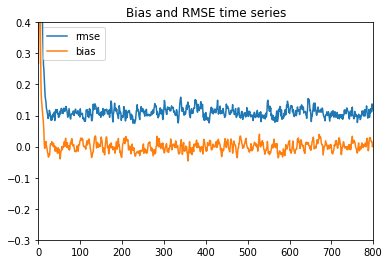

rmse= 0.10976887660626393
bias= 0.00016977399241105756


In [56]:
analysis_error = x_a_save - x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)


plt.plot(rmse_t, label ="rmse")
plt.plot(bias_t, label ="bias")
plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)
#np.savetxt('ENKF_k20_l10_bias.txt',bias_t)
#np.savetxt('ENKF_k20_l10_rmse.txt',rmse_t)

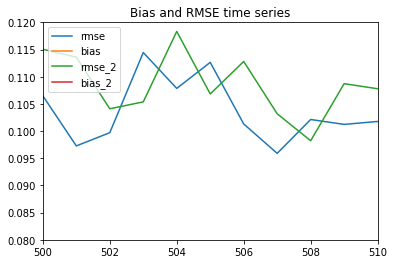

rmse= 0.11769137090231448
bias= 0.00032730227599766045


In [47]:
background_error = x_b_save - x_t_save
bias_t_2 = []
rmse_t_2 = []
for i in range(nT):
    
    bias_i = background_error[i][:].mean()
    rmse_i = np.std(background_error[i][:])
    bias_t_2 = np.append(bias_t_2, bias_i)
    rmse_t_2 = np.append(rmse_t_2, rmse_i)

plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label ="bias")
plt.plot(rmse_t_2, label ="rmse_2" )
plt.plot(bias_t_2, label ="bias_2")
plt.ylim(0.08,0.12)
plt.xlim(500,510)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse_2 = rmse_t_2[30:800].mean()
bias_2 = bias_t_2[30:800].mean()
print("rmse=",rmse_2)
print("bias=",bias_2)
#np.savetxt('ENKF_k200_l10_modelerror0.08_bias.txt',bias_t)
#np.savetxt('ENKF_k200_l10_modelerror0.08_rmse.txt',rmse_t)

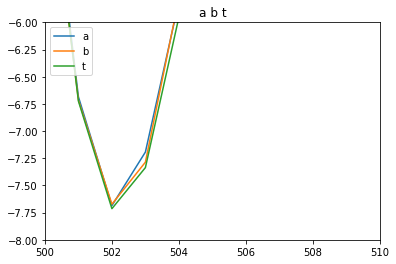

In [34]:
plt.plot(x_a_save[:,10], label ="a" )
plt.plot(x_b_save[:,10], label ="b")
plt.plot(x_t_save[:,10], label ="t" )

plt.xlim(500,510)
plt.ylim(-8,-6)
plt.legend(loc="upper left")
plt.title("a b t")
plt.show()

input B 3.3760000000000003
9.980581182311418


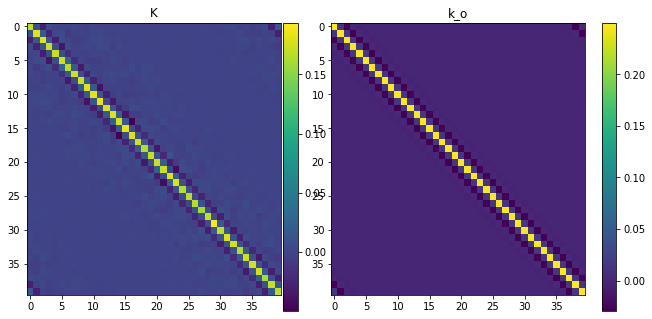

7.0072255344377465
9.980581182311418


In [44]:
B = np.genfromtxt('B.txt')
print("input B", np.trace(B))
K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B, H))+R)))
K_o = np.reshape(K_i, [1,40,40])
print(np.trace(K_i))



fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('K')
plt.imshow(np.mean(K,axis = 0))
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.08, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('k_o')
plt.imshow(np.reshape(K_o,[40,40]))
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.08, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()
print(np.trace(np.mean(K,axis = 0)))
print(np.trace(np.reshape(K_o,[40,40])))

In [21]:
print(np.mean(K,axis = 0).shape)

(40, 40)


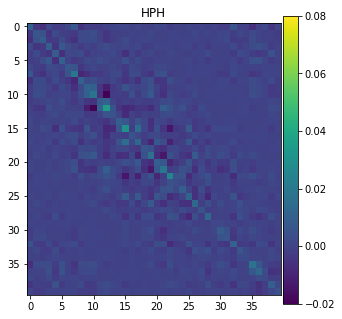

In [69]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('HPH')
plt.imshow(locallization(HPH),vmin=-0.02,vmax=0.08)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B')
plt.imshow(B, vmin=-0.02,vmax=0.08)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

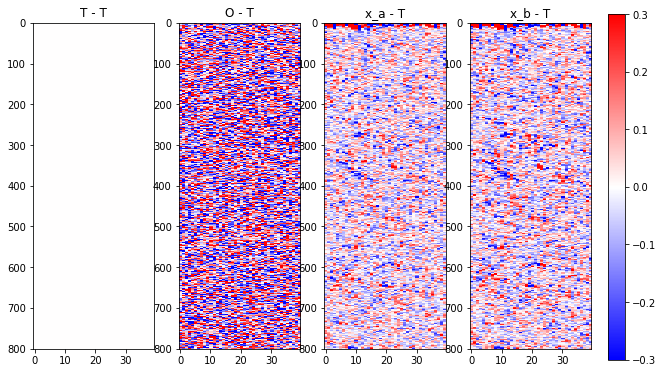

In [70]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('T - T')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('O - T')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('x_a - T')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('x_b - T')
plt.imshow(x_b_save[0:801][:]-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(0, 40), ylim=(0, 40))

ax.set_title('B')
ax.set_aspect('auto')

#line, = ax.plot([], [], lw=2)
a = np.random.random((40,40))
im = plt.imshow(a,interpolation='none', vmin=-0.02, vmax =0.06)
# initialization function: plot the background of each frame
def init():
    im.set_data(np.random.random((40,40)))
           
    cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    return [im]

# animation function.  This is called sequentially
def animate(i):

    a = np.reshape(np.split(K,ttf+1)[i], [40,40])
    im.set_array(a)

    return [im]

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=10, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
# Plot time series of a single grid point
bias_v = []
rmse_v = []

for i in range(N):
    pt = i
    plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_a_save[:,pt-1]-x_t_save[:,pt-1]).mean()
    print("bias = ", bias_i)
    rmse_i = np.std(x_a_save[:,pt-1]-x_t_save[:,pt-1])
    print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    
    plt.xlabel(r'$t$', size=18)
    plt.ylabel(r'$x$', size=18)
    plt.xlim(0,3)
    plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    plt.show()
    plt.close()